In [1]:
from tensorflow import keras
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import LearningRateScheduler
import numpy as np
import tensorflow as tf
from sklearn.utils import shuffle
from tensorflow.keras import models
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from matplotlib import pyplot as plt

2022-11-21 12:56:31.942082: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-21 12:56:32.088692: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-21 12:56:32.830493: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-11-21 12:56:32.830612: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [2]:
dataset = pd.read_csv("../Datasets/ENB2012_data.csv")
dataset = shuffle(dataset)
x_test = dataset.iloc[:50,:]
x_test = dataset.iloc[:50,:]
x_train = dataset.iloc[50:,:]
y_train = x_train.iloc[:,-2:]
y_test = x_test.iloc[:,-2:]
x_train = x_train.iloc[:,:-2]
x_test = x_test.iloc[:,:-2]
x_train_dummy = pd.get_dummies(x_train.iloc[:,-1])
x_test_dummy = pd.get_dummies(x_test.iloc[:,-1])
x_train['0'] = x_train_dummy.iloc[:,0]
x_train['1'] = x_train_dummy.iloc[:,1]
x_train['2'] = x_train_dummy.iloc[:,2]
x_train['3'] = x_train_dummy.iloc[:,3]
x_train['4'] = x_train_dummy.iloc[:,4]
x_train['5'] = x_train_dummy.iloc[:,5]
x_train.pop('X8')
x_test['0'] = x_test_dummy.iloc[:,0]
x_test['1'] = x_test_dummy.iloc[:,1]
x_test['2'] = x_test_dummy.iloc[:,2]
x_test['3'] = x_test_dummy.iloc[:,3]
x_test['4'] = x_test_dummy.iloc[:,4]
x_test['5'] = x_test_dummy.iloc[:,5]
x_test.pop('X8')

417    3
167    3
708    4
293    1
487    5
463    4
665    3
381    2
317    1
6      0
80     1
341    2
393    3
477    4
125    2
298    1
763    5
658    3
468    4
214    4
362    2
14     0
402    3
274    5
284    5
582    2
673    4
538    1
728    5
557    1
458    4
231    4
653    3
646    3
495    5
449    4
644    3
547    1
149    3
572    1
204    4
476    4
761    5
255    5
161    3
123    2
227    4
546    1
104    2
269    5
Name: X8, dtype: int64

In [3]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [4]:
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
scaler.fit(y_train)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [5]:
def EnergyEff():
    model = models.Sequential()
    model.add(layers.Dense(50, activation='relu', input_shape=(x_train.shape[1],)))
    model.add(layers.Dense(1,activation=keras.activations.softsign))
    model.compile(loss=keras.losses.MAE, optimizer='SGD')
    return model

In [6]:
lrs = []
K1 = 0.
epochs = 2000
batch_size=64
num_classes = 2

In [7]:
model_const = EnergyEff() 
K.set_value(model_const.optimizer.learning_rate, 0.1)
history = model_const.fit(x=x_train, y=y_train, epochs=epochs, batch_size=batch_size, verbose=0, validation_data=(x_test, y_test))

2022-11-21 12:56:35.484307: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-21 12:56:35.484398: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-21 12:56:35.484434: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LAPTOP-CN1DC8GL): /proc/driver/nvidia/version does not exist
2022-11-21 12:56:35.485431: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
model_adapt = EnergyEff()
func = K.function([model_adapt.layers[0].input], [model_adapt.layers[-2].output])
def lr_schedule(epoch):
    global K1

    Kz = 0.
    
    for i in (range((len(x_train) - 1) // batch_size + 1)):
      start_i = i * batch_size
      end_i = start_i + batch_size
      xb = x_train[start_i:end_i]
    
      tmp = np.array(func([xb]))
      activ = np.linalg.norm(tmp)
      
      if activ > Kz:
          Kz = activ
    K1 = (1/batch_size)*(Kz)*(1/num_classes)
    lr = 1 / K1
    lrs.append(lr)
    return lr


In [9]:
lr_scheduler = LearningRateScheduler(lr_schedule)

In [10]:
history_lalr=model_adapt.fit(x_train, y_train, epochs = epochs, verbose=0, batch_size = batch_size,validation_data=(x_test,y_test),callbacks=[lr_scheduler])

373
1726


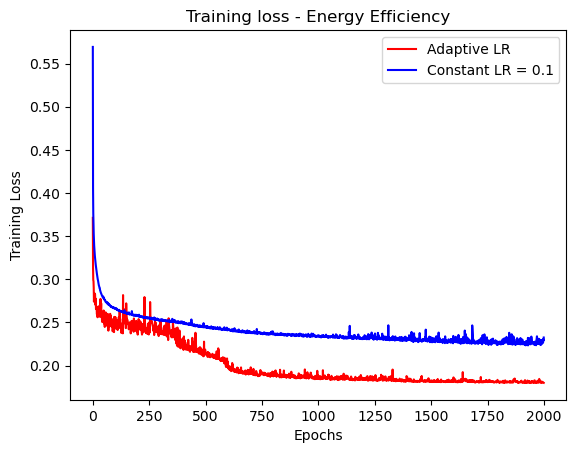

In [16]:
loss_adaptive = history_lalr.history['loss']
loss_constant = history.history['loss']
# to print value just less than threshold
# for x in loss_adaptive:
#     if(x<0.225):
#         print(loss_adaptive.index(x))
#         break
# for x in loss_constant:
#     if(x<0.225):
#         print(loss_constant.index(x))
#         break
epochs = range(len(loss_adaptive))
plt.plot(epochs, loss_adaptive, 'r', label='Adaptive LR')
plt.plot(epochs, loss_constant, 'b',label='Constant LR = 0.1')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training loss - Energy Efficiency')
plt.legend()


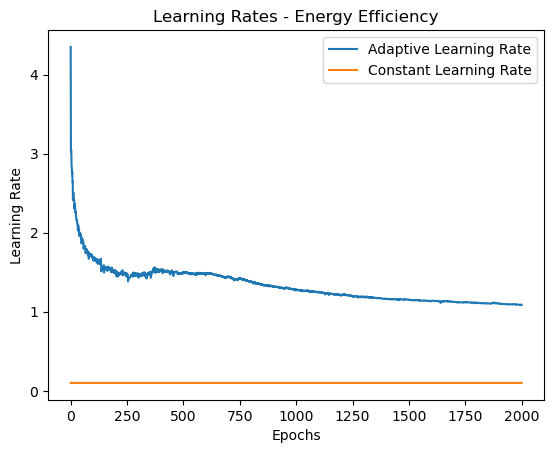

In [12]:
plt.title('Learning Rates - Energy Efficiency')
plt.plot(epochs, lrs, label='Adaptive Learning Rate')
plt.plot(epochs, [0.1]*len(epochs), label ='Constant Learning Rate')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.legend()